In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [2]:
def plot_rsrc(data, node_type):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.start_on, y=data.node_cnt, mode='lines', name=node_type))
    fig.update_layout(showlegend=True)

    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [3]:
data_src = 'lease_info_tacc'
nt = 'compute_haswell'
slot = 24  # length of the interval in hours for resampling
rw = 4  # size of rolling window
time_range = (pd.Timestamp(2018, 1, 1), pd.Timestamp(2021, 6, 1))  # subset of the original dataset

In [4]:
node_data = pd.read_csv('%s/on_demand/%s.csv' % (data_src, nt))
node_data.sort_values(by=['start_on'], inplace=True)

node_data.shape

(16196, 12)

In [5]:
plot_rsrc(node_data, nt)

## Step 1. Resample by a time slot

Counting the number of nodes assigned to Chameleon users within a fixed time interval.

In [6]:
def resample_sum(data, slot):
    rs_sum = pd.DataFrame([])
    rs_sum['start_on'] = pd.to_datetime(data.start_on)
    rs_sum['node_cnt'] = data.node_cnt
    rs_sum = rs_sum.set_index('start_on', drop=True)
    rs_sum = rs_sum.resample('%dH' % slot).sum().fillna(0)
    rs_sum.reset_index(inplace=True)
    return rs_sum

In [7]:
def get_roll_avg(data, slot):
    roll_avg = pd.DataFrame([])
    roll_avg['start_on'] = pd.to_datetime(data.start_on)
    roll_avg['node_cnt'] = data.rolling(slot).mean()
    return roll_avg

In [8]:
rs_node_data = resample_sum(node_data, slot)
# rs_node_data = get_roll_avg(rs_node_data, rw)
rs_node_data.dropna(inplace=True)

In [9]:
rs_node_data

,start_on,node_cnt
0,2018-03-14,4
1,2018-03-15,8
2,2018-03-16,10
3,2018-03-17,10
4,2018-03-18,10
...,...,...
1177,2021-06-03,5
1178,2021-06-04,10
1179,2021-06-05,0
1180,2021-06-06,3


In [10]:
rs_node_data.shape

(1182, 2)

In [11]:
node_data = pd.read_csv('%s/on_demand/%s.csv' % (data_src, nt))
node_data.sort_values(by=['start_on'], inplace=True)

plot_rsrc(rs_node_data, nt)

In [12]:
rs_node_data = rs_node_data[(rs_node_data.start_on > time_range[0]) & (rs_node_data.start_on < time_range[1])]
plot_rsrc(rs_node_data, nt)

In [13]:
rs_node_data.shape

(1175, 2)

## Step 2. Stationarity(ADF) Test

In [14]:
from statsmodels.tsa.stattools import adfuller

def plot_roll_val(timeseries, rw):
    #Determing rolling statistics:
    rolmean=timeseries['node_cnt'].rolling(window=rw).mean()
    rolstd=timeseries['node_cnt'].rolling(window=rw).std()
    
    fig=plt.figure(figsize=(15,8))
    orig=plt.plot(timeseries['node_cnt'],color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def test_stationarity(timeseries):
    t = adfuller(timeseries)
    output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]
    output['value']['Number of Observations Used'] = t[3]
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']
    print(output)
    return output

In [15]:
results = test_stationarity(rs_node_data.node_cnt)

                                   value
Test Statistic Value            -4.79776
p-value                      5.49249e-05
Lags Used                             18
Number of Observations Used         1156
Critical Value(1%)              -3.43602
Critical Value(5%)              -2.86404
Critical Value(10%)              -2.5681


### Compute the firt order difference if timeseries is non-stationary

In [16]:
do_fod = False
if results['value']['Test Statistic Value'] > results['value']['Critical Value(1%)']:
    rs_node_data_diff = rs_node_data.shift(1)
    rs_node_data.node_cnt = rs_node_data.node_cnt - rs_node_data_diff.node_cnt
    rs_node_data = rs_node_data.dropna()
    plot_rsrc(rs_node_data, nt)
    do_fod = True

In [17]:
if do_fod:
    test_stationarity(rs_node_data.node_cnt)

In [18]:
# plot_roll_val(rs_node_data, rw)

In [19]:
rs_node_data = rs_node_data.set_index('start_on', drop=True)

## Step 3. Seasonality Test

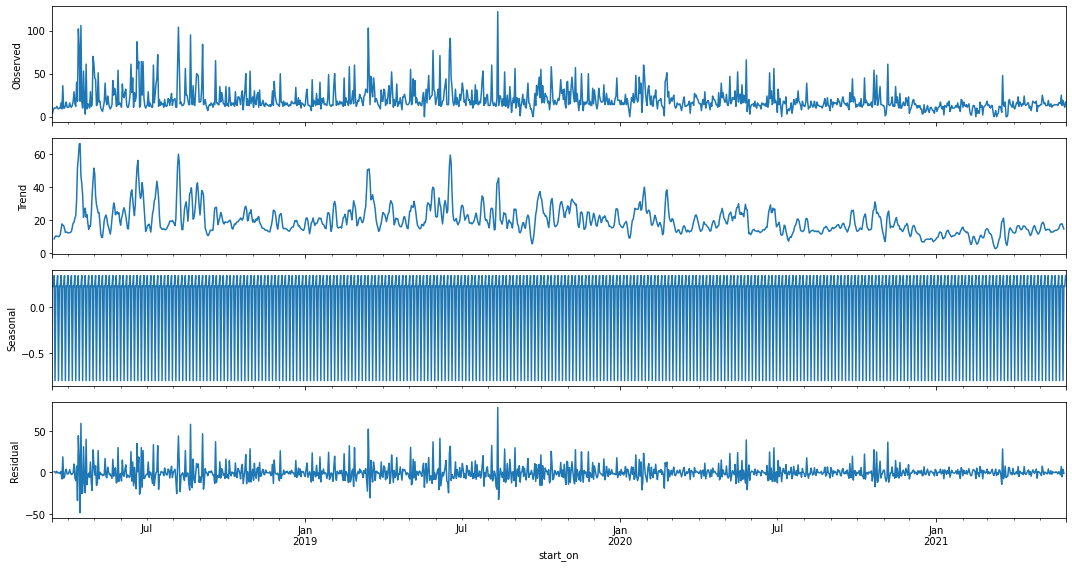

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,8))

tmp = rs_node_data.node_cnt
result = seasonal_decompose(tmp, model='additive', period=rw, two_sided=True)
plotseasonal(result, axes)
plt.tight_layout()
plt.show()

## Step 4. Determine order(p, d, q)

### ACF and PACF 

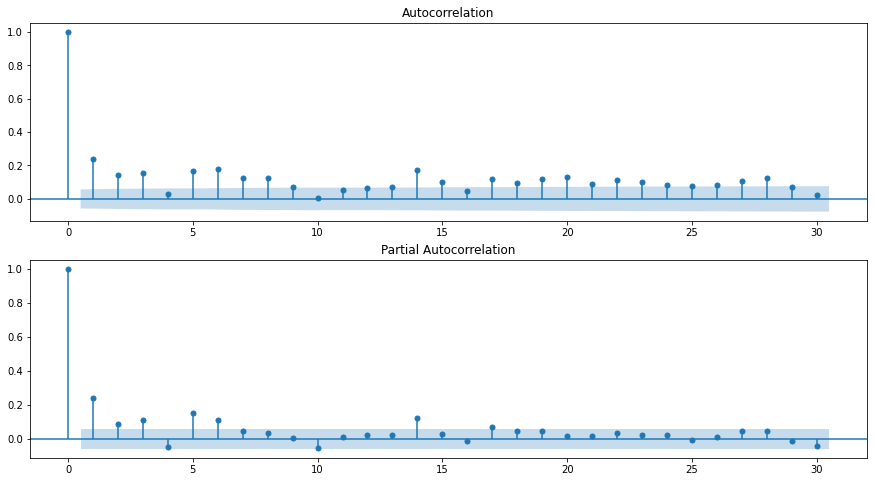

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
tmp = rs_node_data.node_cnt
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(tmp, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(tmp, lags=30, ax=ax2)

### Determin the optimal order(p, q) using AIC

In [22]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.api as sm

pq = sm.tsa.arma_order_select_ic(rs_node_data, max_ar=7, max_ma=7, ic='aic', trend='c')['aic_min_order']
pdq = (pq[0], int(do_fod), pq[1])
print('ARMA(p,q) =',pq,'is the best.')

ARMA(p,q) = (6, 6) is the best.


## Step 5. Determine seasonal_order(sp,sd,sq,s) 

parameter s:
- 1 for yearly
- 4 for quarterly
- 12 for monthly
- 52 for weekly
- 365 for daily

In [23]:
import itertools

def get_ARIMA_params(data, s):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
    return param_seasonal

In [24]:
param_seasonal = get_ARIMA_params(rs_node_data.node_cnt, 12)

x(1, 2, 2, 12)12 - AIC:8977.970895625878


## Step 6. Build SARIMAX Model

In [25]:
from sklearn.model_selection import train_test_split

def rmse(pred, obs):
    return np.sqrt(sum((pred-obs)**2)/pred.shape[0])

def model_forecast(train, test_start, test_end):
    mod = sm.tsa.statespace.SARIMAX(train.node_cnt,
                                    order=pdq,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    # mod_fit.summary()
    rlt = mod_fit.predict(test_start, test_end)
    return rlt.to_frame()

def forward_valid(data, steps):
    predictions = pd.DataFrame([])
    start_on = rs_node_data.index
    train_end = int(rs_node_data.shape[0] * 0.8)
    test_start = int(rs_node_data.shape[0] * 0.8)+1
    test = rs_node_data.iloc[test_start:]
    while test_start+steps < len(start_on):
        pred = model_forecast(rs_node_data.iloc[:train_end], start_on[test_start], start_on[test_start+steps])
        predictions = predictions.append(pred)
        train_end = train_end + steps
        test_start = train_end + 1
    predictions.index.name = 'start_on'
    predictions = predictions.join(test).dropna()
    error = rmse(predictions.predicted_mean, predictions.node_cnt)
    return predictions, error

In [26]:
predictions, error = forward_valid(rs_node_data, 7)

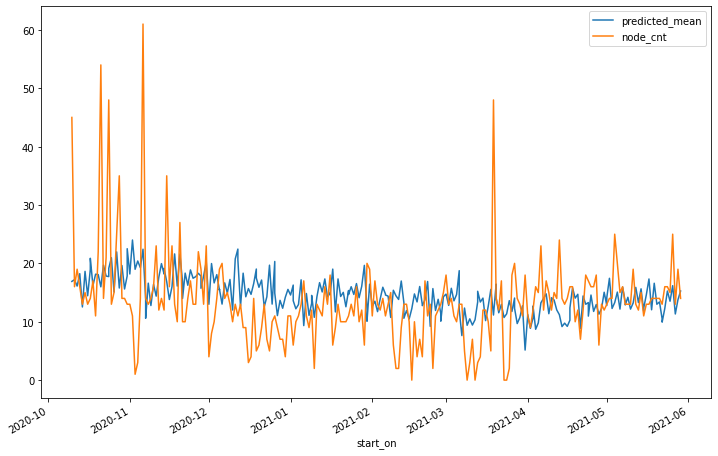

In [27]:
predictions.plot(figsize=(12,8))
plt.legend(loc='best')
plt.show()

In [28]:
print('RMSE: ', error)

RMSE:  7.968924486207253
